## Import libraries

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import operator
%matplotlib inline

## Set global variables

In [45]:
#######################################################
############# Changeable parameters ###################
#######################################################
Mc = 100 # number of coach seats on plane
Mf = 20 # number of first class seats on plane

T = 365 # days until takeoff

# Set Coach Prices
price_c_L = 300
price_c_H = 350
# Set First Class Prices
price_f_L = 425
price_f_H = 500


pcL = [0.35,0.65] # demand probabilities for coach low price
pcH = [0.7,0.3] # demand probabilities for coach high price
pfL = [0.92,0.08] # demand probabilities for first class low price
pfH = [0.96,0.04] # demand probabilities for first class high price

#########################################################
############# End of changeable parameters ##############
#########################################################


In [46]:
# Calculate remaining parameters
delta = 1 / (1+(0.17/T)) # discount rate
scValues = np.arange(Mc+1) # all possible number of coach seats left
sfValues = np.arange(Mf+1) # all possible number of first class seats left

tValues = np.arange(T+1) # all possible days until takeoff

scN = len(scValues) # count possible state values for coach
sfN = len(sfValues) # count possible state values for first class

tN = len(tValues)

## Define functions for fixed strategy 

In [47]:
def init_cost(O,scN,sfN,tN):
    ''' 
    For a given overbooking cap, calculates the cost of bumping / kicking off passengers on the final day of time period (has a caching functionality)
    Input:
    O - Overbooking cap for which we want to calculate final day costs
    scN - count possible state values for coach
    sfN - count possible state values for first class
    tN - Total no of time periods

    Output: 
    V - 3x3 Zero value initialized value matrix with the last column filled with cost values associated with every combination of seats booked in coach and first class
    '''
    

    V = np.zeros((scN+O,sfN, tN)) # initialize value function
    name = "V_init_"+str(O)+".csv"

    # Cache the results in a csv file for given value of O (overbook cap) since calculation takes a lot of time.
    # Try to load csv file first, if it doesnt exist, only then perform the calculations.
    try:
        # Read csv file
        V = pd.read_csv(name).iloc[:,1]
        V = np.array(V).reshape((scN+O,sfN, tN))
        print("Found cache file for O = "+str(O))
        
    except:
        # If no csv file (cache) found, perform the calculations
        print("No cache file found for O = "+str(O))
        # boundary/terminal condition
        # Need to calculate boundary conditions for all possible values of seats left in first class and coach
        for sc in range(scN+O): # for every possible value of seats left in coach
            for sf in range(sfN): # for every possible value of seats left in first class

                # Initialize cost vector
                cost_m = np.zeros((scN+O,sfN))

                # In order to calculate expected value of cost, we need to check iterate through every possibility (if n seats are booked, what is the prob that 1 out of n show up,
                # calculate costs for that scenario, multiply by probability of that scenario, then what is the probability that 2 out of n show up, do the same calcs and so forth)
                for c in range(scN+O-sc): # if (scN + O - sc) = nc seats are booked in coach, iterate through 1 in nc show up, 2 in nc show up... nc in nc show up
                    for f in range(sfN-sf): # if (sfN - sf) = nf seats are booked in first class, iterate through 1 in nf show up, 2 in nf show up... nf in nf show up
                        cost = 0
                        # If no of bookings in coach exceed coach capacity and there aren't enough extra seats in first class
                        if c>(scN-1) and ((c-scN+1) > (sfN-1-f)):
                            cost = ((c-scN+1) - (sfN-1-f))*425 + (sfN-1-f)*50
                        # If no of bookings in coach exceed coach capacity and there are enough extra seats in first class
                        elif c>(scN-1) and ((c-scN+1) <= (sfN-1-f)):
                            cost = (c-scN+1)*50
                        # calculate expected value of cost
                        cost_m[c,f] = stats.binom.pmf(c,scN-1+O-sc,0.95)*stats.binom.pmf(f,sfN-1-sf,0.97)*cost
                V[sc,sf,tN-1] = -sum(sum(cost_m[:,:]))
        
        # save the results in a csv file
        v_df = pd.DataFrame(V.flatten())

        v_df.to_csv(name)
        

    
    return V


In [48]:
def get_optimal_pricing(O=5):

    ''' 
    For a given overbooking cap, calculates the ideal value matrix and ideal path matrix for airline revenue and flight ticket prices
    Input:
    O (default value 5) - Overbooking cap for which we want to calculate ideal value and path matrices

    Output: 
    [V,U] - Array containing 2 elements: V - Ideal Value matrix (revenue), U - Ideal path matrix
    
    '''

    # REMEMBER: O is the OVERBOOKING CAP i.e how many tickets can we sell ABOVE the usual no. of coach seats
    # So if O = 5 and seats in coach Mc = 100, that means total tickets that can be sold in coach = 100 + 5 = 105

    
    V = init_cost(O,scN,sfN,tN)
    U = np.zeros((scN+O,sfN, tN)) # initialize optimal choice variable

    # boundary/terminal condition
    # Need to calculate boundary conditions for all possible values of

    
    U[:,:,tN-1] = 5 # 5 is the value for no tickets for sale (there are 4 choices we can make in this strategy, so 1 - 4 is used, we use 5 to indicate no ticket sale)




    for t in reversed(range(tN-1)):
        for sc in range(0,scN+O):
            for sf in range(sfN):

                # Reset value of probabilities of all classes
                # Default probability if there are seats available in both coach and first class
                pcL_f = pcL # demand probabilities for coach low price
                pcH_f = pcH # demand probabilities for coach high price
                pfL_f = pfL # demand probabilities for first class low price
                pfH_f = pfH # demand probabilities for first class high price

                # Depending on which seats are available in which class, we change the probabilities
                if sf==0 and sc==0: # if the flight full (0 seats left and fully overbooked)
                    # Change probabilities of coach class buy
                    pcL_f = [1,0] # demand probabilities for coach low price
                    pcH_f = [1,0] # demand probabilities for coach high price
                    pfL_f = [1,0] # demand probabilities for first class low price
                    pfH_f = [1,0] # demand probabilities for first class high price
                    

                elif sf==0 and sc>0: # if first class is full but coach is not
                    # Change probabilities of coach class buy
                    pcL_f = list(map(operator.add, pcL_f, [-0.03, 0.03])) # demand probabilities for coach low price
                    pcH_f = list(map(operator.add, pcH_f, [-0.03, 0.03])) # demand probabilities for coach low price # demand probabilities for coach high price
                    pfL_f = [1,0] # demand probabilities for first class low price
                    pfH_f = [1,0] # demand probabilities for first class high price
                elif sf>0 and sc==0: # if coach is full but first class is not
                    pcL_f = [1,0] # demand probabilities for coach low price
                    pcH_f = [1,0] # demand probabilities for coach high price
                    pfL_f = [0.92,0.08] # demand probabilities for first class low price
                    pfH_f = [0.96,0.04] # demand probabilities for first class high price


                # value if you set the price high-high
                # expected revenue from high coach price + expected revenue from high first class price + discounted expected value function next time
                valueHH = pcH_f[1]*price_c_H +pfH_f[1]*price_f_H + delta* (pcH_f[0]*pfH_f[0]*V[sc,sf,t+1] + pcH_f[0]*pfH_f[1]*V[sc,sf-1,t+1] + pcH_f[1]*pfH_f[0]*V[sc-1,sf,t+1] + pcH_f[1]*pfH_f[1]*V[sc-1,sf-1,t+1])
                

                # value if you set the price high-low
                # expected revenue from high coach price + expected revenue from low first class price + discounted expected value function next time
                valueHL = pcH_f[1]*price_c_H +pfL_f[1]*price_f_L + delta* (pcH_f[0]*pfL_f[0]*V[sc,sf,t+1] + pcH_f[0]*pfL_f[1]*V[sc,sf-1,t+1] + pcH_f[1]*pfL_f[0]*V[sc-1,sf,t+1] + pcH_f[1]*pfL_f[1]*V[sc-1,sf-1,t+1])
                


                # value if you set the price low-high
                # expected revenue from low coach price + expected revenue from high first class price + discounted expected value function next time
                valueLH = pcL_f[1]*price_c_L +pfH_f[1]*price_f_H + delta* (pcL_f[0]*pfH_f[0]*V[sc,sf,t+1] + pcL_f[0]*pfH_f[1]*V[sc,sf-1,t+1] + pcL_f[1]*pfH_f[0]*V[sc-1,sf,t+1] + pcL_f[1]*pfH_f[1]*V[sc-1,sf-1,t+1])
        

                # value if you set the price low-low
                # expected revenue from low coach price + expected revenue from low first class price + discounted expected value function next time
                valueLL = pcL_f[1]*price_c_L +pfL_f[1]*price_f_L + delta* (pcL_f[0]*pfL_f[0]*V[sc,sf,t+1] + pcL_f[0]*pfL_f[1]*V[sc,sf-1,t+1] + pcL_f[1]*pfL_f[0]*V[sc-1,sf,t+1] + pcL_f[1]*pfL_f[1]*V[sc-1,sf-1,t+1])
                

                V[sc,sf,t]=max(valueLL,valueLH,valueHL,valueHH) # value funciton maximizes expected revenue
                U[sc,sf,t]=np.argmax([valueLL,valueLH,valueHL,valueHH])+1 # choice of price: 1 means low-low price, 2 means low-high price, 3 means high-low price, 4 means high-high price
                
                # If no seats available, set optimal path to 5 i.e no tickets available
                if sf==0 and sc==0:
                    U[sc,sf,t]=5 # no tickets for sale

    return [V, U]
    

## Calculate Optimal pricing for each overbooking cap -

In [49]:
# Iterate through various values of overbooking cap (from 5 to 15) and store results in a dictionary
O_dict = {}

for O in range(5,16):
    O_dict[O] = get_optimal_pricing(O) # Store the [V,U] array returned by function in the dictionary as a value where the correspndong key is the overbooking cap O

Found cache file for O = 5
Found cache file for O = 6
Found cache file for O = 7
Found cache file for O = 8
Found cache file for O = 9
Found cache file for O = 10
Found cache file for O = 11
Found cache file for O = 12
Found cache file for O = 13
Found cache file for O = 14
Found cache file for O = 15


In [50]:
# What is the ideal revenue when O = 5?
O_dict[5][0][scN+4,sfN-1,0]

41886.1586241959

## Get optimal revenue

In [51]:
# Find maximum revenue from the list of all value matrices for different overbooking caps

max_val = []
for O in range(5,16):
    max_val.append(O_dict[O][0][scN+O-1,sfN-1,0])

O_dict[5+np.argmax(max_val)][0][scN+4+np.argmax(max_val),sfN-1,0]

42134.62483034169

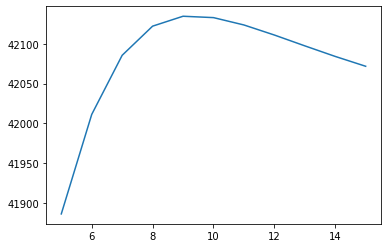

In [52]:
plt.plot(list(range(5,16)),max_val)

In [53]:
# What value of overbooking cap gives us the maximum revenue?
5+np.argmax(max_val)

9

## Define functions alternate strategy

In [54]:
def get_optimal_pricing_alt():
    ''' 
    Calculates the ideal value matrix and ideal path matrix for airline revenue and flight ticket prices with no overbooking cap.
    Remember, this is the same as the fixed overbooking cap strategy, however, the airline has an additional 3rd choice available for coach seats each day; they can choose
    NOT to sell any seats even if there are seats available. In the previous strategy, if there were coach seats available, the airline HAD to sell them if a purchase was made
    Input:
    None
    Output: 
    [V,U] - Array containing 2 elements: V - Ideal Value matrix (revenue), U - Ideal path matrix
    
    '''

    O = Mf # All seats in first class available for overbooking
    V = init_cost(O,scN,sfN,tN)
    U = np.zeros((scN+O,sfN, tN)) # initialize optimal choice variable
    
    # boundary/terminal condition
    # Need to calculate boundary conditions for all possible values of seats left in coach and first class

    
    U[:,:,tN-1] = 7 # 7 is the value for no tickets for sale (there are 6 choices we can make in this strategy, so 1 - 6 is used, we use 7 to indicate no ticket sale)



    for t in reversed(range(tN-1)):
        for sc in range(0,scN+O):
            for sf in range(sfN):

                # Reset value of probabilities of all classes
                # Default probability if there are seats available in both coach and first class
                pcL_f = pcL # demand probabilities for coach low price
                pcH_f = pcH # demand probabilities for coach high price
                pfL_f = pfL # demand probabilities for first class low price
                pfH_f = pfH # demand probabilities for first class high price

                # Depending on which seats are available in which class, we change the probabilities
                if sf==0 and sc==0: # if the flight full (0 seats left and fully overbooked)
                    # Change probabilities of coach class buy
                    pcL_f = [1,0] # demand probabilities for coach low price
                    pcH_f = [1,0] # demand probabilities for coach high price
                    pfL_f = [1,0] # demand probabilities for first class low price
                    pfH_f = [1,0] # demand probabilities for first class high price
                    

                elif sf==0 and sc>0: # if first class is full but coach is not
                    # Change probabilities of coach class buy
                    pcL_f = list(map(operator.add, pcL_f, [-0.03, 0.03])) # demand probabilities for coach low price
                    pcH_f = list(map(operator.add, pcH_f, [-0.03, 0.03])) # demand probabilities for coach low price # demand probabilities for coach high price
                    pfL_f = [1,0] # demand probabilities for first class low price
                    pfH_f = [1,0] # demand probabilities for first class high price
                elif sf>0 and sc==0: # if coach is full but first class is not
                    pcL_f = [1,0] # demand probabilities for coach low price
                    pcH_f = [1,0] # demand probabilities for coach high price
                    pfL_f = [0.92,0.08] # demand probabilities for first class low price
                    pfH_f = [0.96,0.04] # demand probabilities for first class high price


                # value if you set the price high-high
                # expected revenue from high coach price + expected revenue from high first class price + discounted expected value function next time
                valueHH = pcH_f[1]*price_c_H +pfH_f[1]*price_f_H + delta* (pcH_f[0]*pfH_f[0]*V[sc,sf,t+1] + pcH_f[0]*pfH_f[1]*V[sc,sf-1,t+1] + pcH_f[1]*pfH_f[0]*V[sc-1,sf,t+1] + pcH_f[1]*pfH_f[1]*V[sc-1,sf-1,t+1])
                

                # value if you set the price high-low
                # expected revenue from high coach price + expected revenue from low first class price + discounted expected value function next time
                valueHL = pcH_f[1]*price_c_H +pfL_f[1]*price_f_L + delta* (pcH_f[0]*pfL_f[0]*V[sc,sf,t+1] + pcH_f[0]*pfL_f[1]*V[sc,sf-1,t+1] + pcH_f[1]*pfL_f[0]*V[sc-1,sf,t+1] + pcH_f[1]*pfL_f[1]*V[sc-1,sf-1,t+1])
                


                # value if you set the price low-high
                # expected revenue from low coach price + expected revenue from high first class price + discounted expected value function next time
                valueLH = pcL_f[1]*price_c_L +pfH_f[1]*price_f_H + delta* (pcL_f[0]*pfH_f[0]*V[sc,sf,t+1] + pcL_f[0]*pfH_f[1]*V[sc,sf-1,t+1] + pcL_f[1]*pfH_f[0]*V[sc-1,sf,t+1] + pcL_f[1]*pfH_f[1]*V[sc-1,sf-1,t+1])
        

                # value if you set the price low-low
                # expected revenue from low coach price + expected revenue from low first class price + discounted expected value function next time
                valueLL = pcL_f[1]*price_c_L +pfL_f[1]*price_f_L + delta* (pcL_f[0]*pfL_f[0]*V[sc,sf,t+1] + pcL_f[0]*pfL_f[1]*V[sc,sf-1,t+1] + pcL_f[1]*pfL_f[0]*V[sc-1,sf,t+1] + pcL_f[1]*pfL_f[1]*V[sc-1,sf-1,t+1])
                
                
                ### This is where the strategy differs, we define an additional TWO values (since there is a 3rd choice that we can make, so total choices = 3*2 = 6) #####


                # value if you set the price no sale-low
                # expected revenue from no sale coach + expected revenue from low first class price + discounted expected value function next time
                valueNL = 0 + pfL_f[1]*price_f_L + delta* (pfL_f[0]*V[sc,sf,t+1] + pfL_f[1]*V[sc,sf-1,t+1])

                # value if you set the price no sale-high
                # expected revenue from no sale coach + expected revenue from high first class price + discounted expected value function next time
                valueNH = 0 + pfH_f[1]*price_f_H + delta* (pfH_f[0]*V[sc,sf,t+1] + pfH_f[1]*V[sc,sf-1,t+1])

                V[sc,sf,t]=max(valueLL,valueLH,valueHL,valueHH,valueNL,valueNH) # value funciton maximizes expected revenue
                U[sc,sf,t]=np.argmax([valueLL,valueLH,valueHL,valueHH,valueNL,valueNH])+1 # choice of price: 1 means low-low price, 2 means low-high price, 3 means high-low price, 4 means high-high price, 5 means no sale-low, 6 means no sale-high
                
                # If no seats available, set optimal path to 7 i.e no tickets available
                if sf==0 and sc==0:
                    U[sc,sf,t]=7 # no tickets for sale

    return [V, U]

In [55]:
O_alt = get_optimal_pricing_alt()

Found cache file for O = 20


In [56]:
O_alt[0][120,20,0]

42139.89276231979

## Simulation for optimal booking strategy

In [57]:
def simulate(strategy = 'fixed',N=10000):

    ''' 
    For a given strategy, carry out simulation of ticket sales and people who show up on the last day and return various metrics

    Input:

    strategy (default value 'fixed') - The strategy used for simulation. If 'fixed' then we use the first approach where overbooking cap is fixed. We use the path matrix U
    corresponding to the overbooking cap that gave the optimal revenue.

    N (default value 10000) - No. of times you want to run the simulation

    Output:

    overbooked_vec - Vector of size 1xN where each value corresponds to the # of people overbooked for the flight on the last day per each simulation
    bumped_vec - Vector of size 1xN where each value corresponds to the # of people bumped from coach to first class for the flight on the last day per each simulation
    kicked_vec - Vector of size 1xN where each value corresponds to the # of people kicked out from coach for the flight on the last day per each simulation
    final_revenue_vec - Vector of size 1xN where each value corresponds to the revenue of the flight on the last day per each simulation
    cost_vec - Vector of size 1xN where each value corresponds to the cost incurred for bumping/kicking off customers from the flight on the last day per each simulation
    
    '''

    # Initialize arrays
    overbooked_vec = np.zeros(N)
    kicked_vec = np.zeros(N)
    bumped_vec = np.zeros(N)
    cost_vec = np.zeros(N)
    final_revenue_vec = np.zeros(N)
    seats_booked_c_vec = np.zeros(N)
    seats_booked_f_vec = np.zeros(N)
    optimal_prices_mat = np.zeros((N,T,2))


    # Choose appropriate values of ideal path matrix and overbooking cap depending on strategy
    if strategy == 'fixed':
        U = O_dict[5+np.argmax(max_val)][1]
        # Set overbooking cap = ideal overbooking cap from first strategy
        overbook_cap = 5+np.argmax(max_val)
    elif strategy == 'alt':
        U = O_alt[1]
        # Set overbooking cap to unlimited (i.e all seats available in first class)
        overbook_cap = Mf
    else:
        print("Invalid strategy: Please select either 'fixed' or 'alt'")
        print("Defaulting to 'fixed'")
        U = O_dict[5+np.argmax(max_val)][1]
        # Set overbooking cap = ideal overbooking cap from first strategy by default
        overbook_cap = 5+np.argmax(max_val)
    


    # Carry out simulation

    for n in range(N):
        
        sc = scN-1+overbook_cap # on the first day all seats are available for coach + all first class seats for overbooking
        sf = sfN-1 # on the first day all seats are available for first class seats
        total_rev = 0 # we haven't made any money yet
        seats_left_vec_coach = np.zeros(tN-1) # store how many seats in coach
        seats_left_vec_first_class = np.zeros(tN-1) # store how many seats in coach
        #print(sc)
        revenue_vec = np.zeros(tN-1)

        price_vec = np.zeros(tN-1)


        for t in range(tN-1): # loop forward in time...don't need last time period since we can't sell anything then


            # Reset value of probabilities of all classes
            # Default probability if there are seats available in both coach and first class
            pcL_f = pcL # demand probabilities for coach low price
            pcH_f = pcH # demand probabilities for coach high price
            pfL_f = pfL # demand probabilities for first class low price
            pfH_f = pfH # demand probabilities for first class high price

            # Encodes U values into ordered pairs, used for optimal_prices_mat
            # 0 indicates no sale, 1 indicates low price, 2 indicates high price
            # first coordinate is coach second is first class
            old_to_new_encod_dic = {1:[1,1], 2:[1,2], 3:[2,1], 4:[2,2], 5:[0,1], 6:[0,2], 7:[0,3]} 
            price_sold = old_to_new_encod_dic[U[sc,sf,t]] # stores how much we should charge.

            # Depending on which seats are available in which class, we change the probabilities
            if sf==0 and sc==0: # if the flight full (0 seats left and fully overbooked)
                # Change probabilities of coach class buy
                pcL_f = [1,0] # demand probabilities for coach low price
                pcH_f = [1,0] # demand probabilities for coach high price
                pfL_f = [1,0] # demand probabilities for first class low price
                pfH_f = [1,0] # demand probabilities for first class high price
                price_sold = [0,0]

            elif sf==0 and sc>0: # if first class is full but coach is not
                # Change probabilities of coach class buy
                pcL_f = list(map(operator.add, pcL_f, [-0.03, 0.03])) # demand probabilities for coach low price
                pcH_f = list(map(operator.add, pcH_f, [-0.03, 0.03])) # demand probabilities for coach low price # demand probabilities for coach high price
                pfL_f = [1,0] # demand probabilities for first class low price
                pfH_f = [1,0] # demand probabilities for first class high price
                price_sold[1] = 0#  Guarantees we record for u2 that first class isn't sold

            elif sf>0 and sc==0: # if coach is full but first class is not
                pcL_f = [1,0] # demand probabilities for coach low price
                pcH_f = [1,0] # demand probabilities for coach high price
                pfL_f = [0.92,0.08] # demand probabilities for first class low price
                pfH_f = [0.96,0.04] # demand probabilities for first class high price
                price_sold[0] = 0 # Guarantees we record that coach isn't sold 

            optimal_prices_mat[n,t,:] = price_sold # Save price sold data to optimal_prices_mat

            
            opt_price = U[sc,sf,t] # how much should we charge
            price_vec[t] = opt_price

            # Depending on the no of seats left in coach and first class, get the value of the optimal choice from the ideal path matrix
            # Depending on ideal choice obtained, set corresponding values of probability of sales and ticket prices in coach and first class

            if opt_price == 1: # low low
                prob_sale_coach = pcL_f[1] # for each value of U find probability of making a sale
                prob_sale_first = pfL_f[1] # for each value of U find probability of making a sale
                actual_price_coach = price_c_L # for each value find actual sale price
                actual_price_first_class = price_f_L # for each value find actual sale price

            elif opt_price == 2: # low high
                prob_sale_coach = pcL_f[1] # for each value of U find probability of making a sale
                prob_sale_first = pfH_f[1] # for each value of U find probability of making a sale
                actual_price_coach = price_c_L # for each value find actual sale price
                actual_price_first_class = price_f_H # for each value find actual sale price

            elif opt_price == 3: # high low
                prob_sale_coach = pcH_f[1] # for each value of U find probability of making a sale
                prob_sale_first = pfL_f[1] # for each value of U find probability of making a sale
                actual_price_coach = price_c_H # for each value find actual sale price
                actual_price_first_class = price_f_L # for each value find actual sale price

            elif opt_price == 4: # high high
                prob_sale_coach = pcH_f[1] # for each value of U find probability of making a sale
                prob_sale_first = pfH_f[1] # for each value of U find probability of making a sale
                actual_price_coach = price_c_H # for each value find actual sale price
                actual_price_first_class = price_f_H # for each value find actual sale price

            elif opt_price == 5: # no sale low or no tickets for sale

                # Caveat - For fixed strategy, we use 5 to indicate no ticket sale but for alternate stragey, 5 is used to indicate no sales (coach) - low price first class
                # So just make sure we pick the right values for purchase probability and ticket prices depending on which strategy is picked when calling function

                if strategy=='fixed': # no tickets for sale
                    prob_sale_coach = 0 # for each value of U find probability of making a sale
                    prob_sale_first = 0 # for each value of U find probability of making a sale
                    actual_price_coach = 0 # for each value find actual sale price
                    actual_price_first_class = 0 # for each value find actual sale price
                else: # no sale low
                    prob_sale_coach = 0 # for each value of U find probability of making a sale
                    prob_sale_first = pfL_f[1] # for each value of U find probability of making a sale
                    actual_price_coach = 0 # for each value find actual sale price
                    actual_price_first_class = price_f_L # for each value find actual sale price

            elif opt_price == 6: # no sale high
                prob_sale_coach = 0 # for each value of U find probability of making a sale
                prob_sale_first = pfH_f[1] # for each value of U find probability of making a sale
                actual_price_coach = 0 # for each value find actual sale price
                actual_price_first_class = price_f_H # for each value find actual sale price

            else: # no tickets for sale
                prob_sale_coach = 0 # for each value of U find probability of making a sale
                prob_sale_first = 0 # for each value of U find probability of making a sale
                actual_price_coach = 0 # for each value find actual sale price
                actual_price_first_class = 0 # for each value find actual sale price


            sale_coach = (np.random.random(1)<prob_sale_coach) # simulate whether a sale was made or not in coach
            sale_first_class = (np.random.random(1)<prob_sale_first) # simulate whether a sale was made or not in first_class
            # when the flight is full the probability of sale is 0, we'll never get a sale

            sc = int(sc - sale_coach) # subtract whether or not a sale was made in coach
            sf = int(sf - sale_first_class) # subtract whether or not a sale was made in first class

            total_rev = total_rev + sale_coach*actual_price_coach*delta**(t-1) + sale_first_class*actual_price_first_class*delta**(t-1)# add discounted revenue
            # save the results
            seats_left_vec_coach[t] = sc 
            seats_left_vec_first_class[t] = sf
            revenue_vec[t] = total_rev


        # How many people actually show up on the last day?

        # Calculate # of seats booked (Not how many people actually show up but what are the no of seats BOOKED)
        seats_booked_coach = scN-1+overbook_cap - sc
        seats_booked_first_class = sfN-1+ - sf
        seats_booked_c_vec[n] = seats_booked_coach
        seats_booked_f_vec[n] = seats_booked_first_class

        # Simulate the last day to see how many people actually show up
        showup_coach = 0
        showup_first_class = 0
        for i in range(seats_booked_coach):
            showup_coach+=np.random.choice([0,1],p=[0.05,0.95])
        for j in range(seats_booked_first_class):
            showup_first_class+=np.random.choice([0,1],p=[0.03,0.97])

        # Based on how many people actually show up, calculate how many people end up being overbooked and store value in array for nth simulation
        overbooked_vec[n] = max(0,showup_coach - Mc)
        # Based on how many people actually show up, calculate how many people end up being bumped from coach to first class and store value in array for nth simulation
        bumped_vec[n] = min(overbooked_vec[n], (Mf - showup_first_class))
        # Based on how many people actually show up, calculate how many people end up being kicked from the flight and store value in array for nth simulation
        kicked_vec[n] = max(0,overbooked_vec[n] - (Mf - showup_first_class))
        # Store value of revenue in array for nth simulation
        final_revenue_vec[n] = revenue_vec[-1]
        # Based on how many people actually show up, calculate costs of people bumped and kicked and store value in array for nth simulation
        cost_vec[n] = (50*bumped_vec[n] + 425*kicked_vec[n])*delta**(tN-2)


    return overbooked_vec, bumped_vec, kicked_vec, final_revenue_vec, cost_vec, seats_booked_c_vec, seats_booked_f_vec, optimal_prices_mat


In [58]:
# Simulate for alternate strategy

overbooked_vec_a, bumped_vec_a, kicked_vec_a, final_revenue_vec_a, cost_vec_a, seats_booked_c_vec_a, seats_booked_f_vec_a, optimal_prices_a = simulate(strategy='alt',N = 10000)
profit_a = list(map(operator.add,final_revenue_vec_a, (np.array(cost_vec_a)*(-1))))

print("Overbooked - ",np.mean(overbooked_vec_a))
print("Bumped - ",np.mean(bumped_vec_a))
print("Kicked - ",np.mean(kicked_vec_a))
print("Cost - ",np.mean(cost_vec_a))
print("Revenue Mean - ",np.mean(final_revenue_vec_a))
print("Revenue Std Dev - ",np.std(final_revenue_vec_a))
print("Profit Mean - ",np.mean(profit_a))
print("Profit Std Dev - ",np.std(profit_a))
print("Seats booked in coach - ",)

Overbooked -  3.2014
Bumped -  0.8353
Kicked -  2.3661
Cost -  884.0652093094693
Revenue Mean -  43020.29940931338
Revenue Std Dev -  893.4636023280586
Profit Mean -  42136.23420000391
Profit Std Dev -  934.5621731766422
Seats booked in coach - 


In [59]:
# Simulate for fixed strategy

overbooked_vec_f, bumped_vec_f, kicked_vec_f, final_revenue_vec_f, cost_vec_f, seats_booked_c_vec_f, seats_booked_f_vec_f, optimal_prices_f = simulate(strategy='fixed',N=10000)
profit_f = list(map(operator.add,final_revenue_vec_f, (np.array(cost_vec_f)*(-1))))

print("Overbooked - ",np.mean(overbooked_vec_f))
print("Bumped - ",np.mean(bumped_vec_f))
print("Kicked - ",np.mean(kicked_vec_f))
print("Cost - ",np.mean(cost_vec_f))
print("Revenue Mean - ",np.mean(final_revenue_vec_f))
print("Revenue Std Dev - ",np.std(final_revenue_vec_f))
print("Profit Mean - ",np.mean(profit_f))
print("Profit Std Dev - ",np.std(profit_f))


Overbooked -  2.9517
Bumped -  0.7421
Kicked -  2.2096
Cost -  823.9891310748853
Revenue Mean -  42976.99567290791
Revenue Std Dev -  895.7170206891274
Profit Mean -  42153.006541833034
Profit Std Dev -  940.0374307022837


In [60]:
kicked_value_counts = pd.DataFrame(kicked_vec_f).value_counts()
len(kicked_value_counts.values)

10

Text(0.5, 0.98, 'Kicked Passengers Histogram')

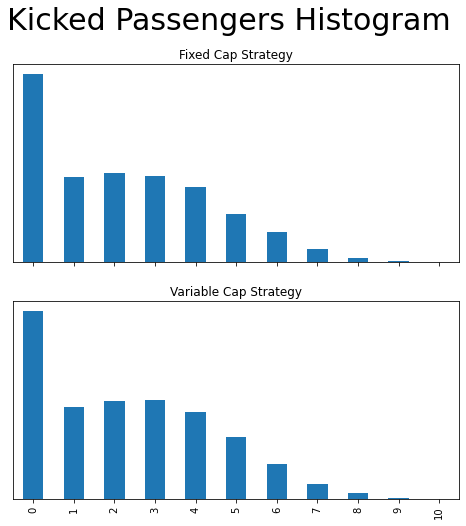

In [62]:
fig, ax = plt.subplots(2,1, sharex = True, figsize = (8,8))


kicked_val_counts = pd.DataFrame(kicked_vec_a).value_counts().sort_index()
kicked_val_counts.index = [str(i) for i in range(10)]
kicked_val_counts.plot(kind = "bar", ax = ax[1])
ax[1].set_title("Variable Cap Strategy")
ax[1].set_yticks([])
ax[1].set_xticklabels(range(10))

kicked_val_counts = pd.DataFrame(kicked_vec_f).value_counts().sort_index()
kicked_val_counts.loc[10] = 0
kicked_val_counts.index = [str(i) for i in range(11)]
kicked_val_counts.plot(kind = "bar", ax = ax[0])
ax[0].set_title("Fixed Cap Strategy")
ax[0].set_yticks([])

fig.suptitle("Kicked Passengers Histogram", fontsize = 30)


<AxesSubplot:xlabel='0'>

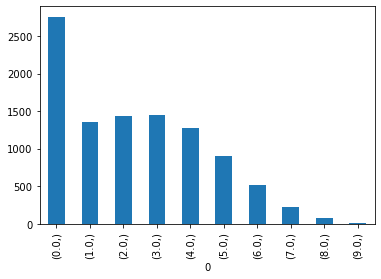

In [63]:
pd.DataFrame(kicked_vec_a).value_counts().sort_index().plot(kind = "bar")

Text(0.5, 0.98, 'Profit Histogram')

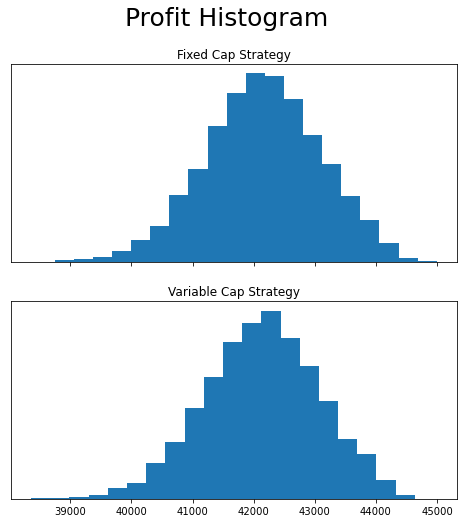

In [64]:
fig, ax = plt.subplots(2,1, sharex = True, figsize = (8,8))
profit_vec_f = final_revenue_vec_f - cost_vec_f
profit_vec_a = final_revenue_vec_a - cost_vec_a

ax[0].hist(final_revenue_vec_f - cost_vec_f, bins = 20)
ax[0].set_title("Fixed Cap Strategy")
ax[0].set_yticks([])


ax[1].hist(final_revenue_vec_a - cost_vec_a, bins = 20)
ax[1].set_title("Variable Cap Strategy")
ax[1].set_yticks([])

fig.suptitle("Profit Histogram", fontsize = 25)

### Plot area graph of prices

In [65]:
# Setup data for plotting
coach_prices_a = pd.DataFrame(optimal_prices_a[:,:,0]) # Convert counts into dataframe
coach_prices_a = coach_prices_a.apply(lambda x: x.value_counts()/len(x)) # Compute Frequencies
coach_prices_a = coach_prices_a.fillna(0) # Fill na
coach_prices_a.index = ["don't sell", "low price", "high price"] # Rename 0,1,2 to their respective meanings

fc_prices_a = pd.DataFrame(optimal_prices_a[:,:,1]) # Convert counts into dataframe
fc_prices_a = fc_prices_a.apply(lambda x: x.value_counts()/len(x)) # Compute Frequencies
fc_prices_a = fc_prices_a.fillna(0) # Fill na
fc_prices_a.index = ["don't sell", "low price", "high price"] # Rename 0,1,2 to their respective meanings

In [66]:
# Setup data for plotting
coach_prices_f = pd.DataFrame(optimal_prices_f[:,:,0]) # Convert counts into dataframe
coach_prices_f = coach_prices_f.apply(lambda x: x.value_counts()/len(x)) # Compute Frequencies
coach_prices_f = coach_prices_f.fillna(0) # Fill na
coach_prices_f.index = ["don't sell", "low price", "high price"] # Rename 0,1,2 to their respective meanings

fc_prices_f = pd.DataFrame(optimal_prices_f[:,:,1]) # Convert counts into dataframe
fc_prices_f = fc_prices_f.apply(lambda x: x.value_counts()/len(x)) # Compute Frequencies
fc_prices_f = fc_prices_f.fillna(0) # Fill na
fc_prices_f.index = ["don't sell", "low price", "high price"] # Rename 0,1,2 to their respective meanings

Text(0.5, 0, 'Day')

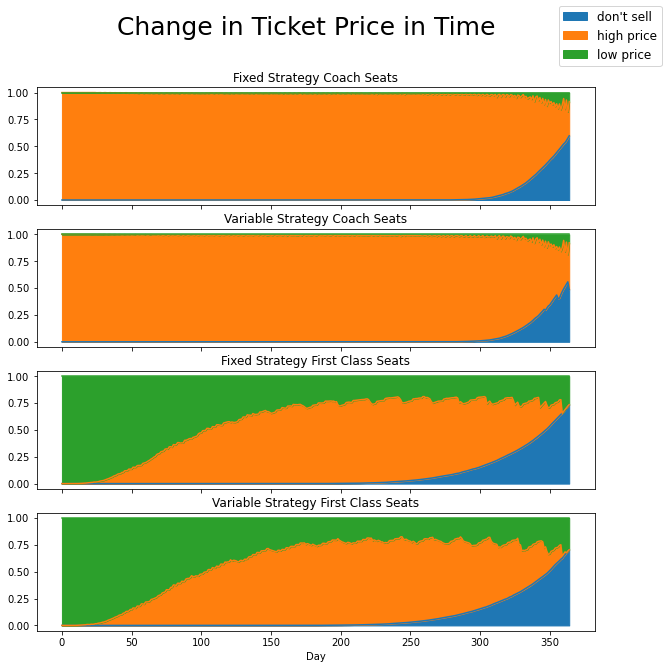

In [67]:
# Plotting
fig, axes = plt.subplots(4,1, clear = True, sharex = True, sharey = True, figsize=(10, 10))
coach_prices_f.transpose()[["don't sell", "high price", "low price"]].plot(kind = "area",
                                                                           ax = axes[0],
                                                                           legend = False)
coach_prices_a.transpose()[["don't sell", "high price", "low price"]].plot(kind = "area",
                                                                           ax = axes[1],
                                                                           legend = False)
fc_prices_f.transpose()[["don't sell", "high price", "low price"]].plot(kind = "area",
                                                                        ax = axes[2],
                                                                        legend = False)
fc_prices_a.transpose()[["don't sell", "high price", "low price"]].plot(kind = "area",
                                                                        ax = axes[3],
                                                                        legend = False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = "upper right", prop={'size': 12})
fig.suptitle("Change in Ticket Price in Time", fontsize = 25)
axes[0].set_title("Fixed Strategy Coach Seats")
axes[1].set_title("Variable Strategy Coach Seats")
axes[2].set_title("Fixed Strategy First Class Seats")
axes[3].set_title("Variable Strategy First Class Seats")
axes[3].set_xlabel("Day")

### Plot distribution of terminal condition

Text(0.5, 15.0, 'First Class Seats')

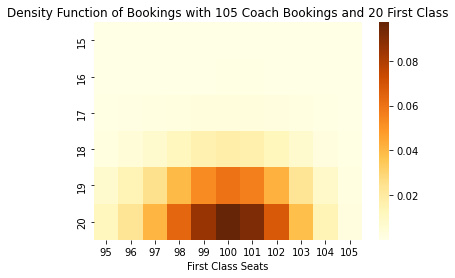

In [68]:
dist = pd.DataFrame([[stats.binom.pmf(i,105,0.95)*stats.binom.pmf(j,20,0.97) for i in range(95,106)] for j in range(15,21)])
dist.index = range(15,21)
dist.columns = range(95,106)
import seaborn as sns
sns.heatmap(dist,cmap=sns.color_palette("YlOrBr", as_cmap=True))
plt.title("Density Function of Bookings with 105 Coach Bookings and 20 First Class")
plt.xlabel("Coach Seats")
plt.xlabel("First Class Seats")

### Measure number of times switching of prices occurs

In [69]:
def deconstruct_price_changes(x):
    '''Takes in a price history as a series, and returns a tuple containing the number of times the price changed,
    and the number of times the price was set to 0'''
    price_change = x[1:].values != x[:-1].values
    n_price_changes = price_change.sum()
    stop_selling = x[1:][price_change] == 0
    n_stop_selling = sum(stop_selling)
    return pd.Series({"Price Changes": n_price_changes, "Stop Selling": n_stop_selling})

In [70]:
# Setup data for plotting
coach_prices_f = pd.DataFrame(optimal_prices_f[:,:,0]) # Convert prices into dataframe
fc_prices_f = pd.DataFrame(optimal_prices_f[:,:,1])

coach_prices_a = pd.DataFrame(optimal_prices_a[:,:,0]) # Convert prices into dataframe
fc_prices_a = pd.DataFrame(optimal_prices_a[:,:,1])

price_changes_coach_f = coach_prices_f.apply(deconstruct_price_changes, axis = 1)
price_changes_coach_a = coach_prices_a.apply(deconstruct_price_changes, axis = 1)
price_changes_fc_f = fc_prices_f.apply(deconstruct_price_changes, axis = 1)
price_changes_fc_a = fc_prices_a.apply(deconstruct_price_changes, axis = 1)

In [71]:
price_changes_coach_f.mean()

Price Changes    6.7716
Stop Selling     0.5975
dtype: float64

In [72]:
price_changes_coach_a.mean()

Price Changes    7.0463
Stop Selling     0.6829
dtype: float64

In [73]:
price_changes_fc_a.mean()

Price Changes    8.7812
Stop Selling     0.7044
dtype: float64

In [74]:
price_changes_fc_f.mean()

Price Changes    8.6799
Stop Selling     0.7351
dtype: float64

$$$$
$$
\begin{alignat*}{}
V(f,c,t) &= \max_{p_f,p_c}\{P(F|p_f)*p_f + P(C|p_c)*p_c +\delta*&  (P(F|p_f)*P(F|p_c)*V(f-1,c-1,t+1)\\
&& + (1-P(F|p_f))*P(C|p_c)*V(f,c-1,t)\\
&& + P(F|p_f)*(1-P(C|p_c))*V(f-1,c,t+1)\\
&& + (1-P(F|p_f))*(1-P(C|p_c))*V(f,c,t+1))\},
\end{alignat*}{}$$